## I. Introduction

- Nama: Riko Fadilah Alam.

Dataset yang digunakan adalah Rock, Paper, Scissors yang bersumber dari Kaggle. Dataset ini berisi gambar-gambar tangan yang membentuk isyarat batu, kertas, dan gunting. Model yang dibangun dari dataset ini dapat digunakan untuk menyelesaikan masalah otomatisasi penilaian atau deteksi isyarat tangan dalam permainan "Batu-Gunting-Kertas".  Meskipun sederhana, pengenalan isyarat tangan "batu-gunting-kertas" dapat menjadi langkah awal untuk membangun sistem pengenalan gerakan tangan yang lebih canggih untuk kontrol perangkat, interaksi virtual, atau bahkan terapi fisik.

url: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors

Objective dari graded challenge ini adalah untuk membangun model untuk Computer Vision yaitu dengan ***Convolutional Neural Network*** (CNN) yang mampu mengklasifikasikan gambar tangan menjadi tiga kategori (batu, kertas, atau gunting) dengan tingkat akurasi yang tinggi. Proyek ini akan mencakup:
1.  Membangun model CNN.
2.  Melakukan improvisasi model dengan menggunakan teknik *Transfer Learning* untuk mendapatkan performa yang lebih baik.
3.  Mengevaluasi kedua model untuk membandingkan performanya dan memilih model terbaik.
4.  Menyimpan model terbaik dan akan digunakan dalam model deployment.

User:
Pengembang Game/Aplikasi: Mereka dapat menggunakan model ini sebagai komponen dasar untuk menciptakan game atau aplikasi interaktif yang lebih kompleks.

Model Deployment: https://huggingface.co/spaces/rfalam/Graded-Challenge-7_Riko_RMT-043 

# II. Import Libraries

In [ ]:
# Downgrade version of TensorFlow and tf-keras

!pip install -q --upgrade "tensorflow<2.16" "tf-keras<2.16"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensor

In [ ]:
# Import Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from skimage.color import rgb2gray

# III. Data Loading.

In [ ]:
# Menyiapkan API Kaggle, mengunduh, dan mengekstrak dataset.

# Siapkan direktori untuk kaggle.json
!mkdir -p ~/.kaggle
# Pindahkan kaggle.json ke direktori yang benar
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Perintah ini akan mengunduh file bernama 'rockpaperscissors.zip'
!kaggle datasets download -d drgfreeman/rockpaperscissors



Dataset URL: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors
License(s): CC-BY-SA-4.0
 81% 248M/306M [00:00<00:00, 743MB/s] 
100% 306M/306M [00:00<00:00, 795MB/s]


In [ ]:
# Ekstrak file zip yang benar

local_zip = 'rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

# Menentukan direktori dasar tempat gambar berada setelah diekstrak


base_dir = 'tmp/rps-cv-images/'
rock_dir = os.path.join(base_dir, 'rock')
paper_dir = os.path.join(base_dir, 'paper')
scissors_dir = os.path.join(base_dir, 'scissors')

# IV. Exploratory Data Analysis (EDA)

## 1. Visualisasi gambar dari tiap kelas

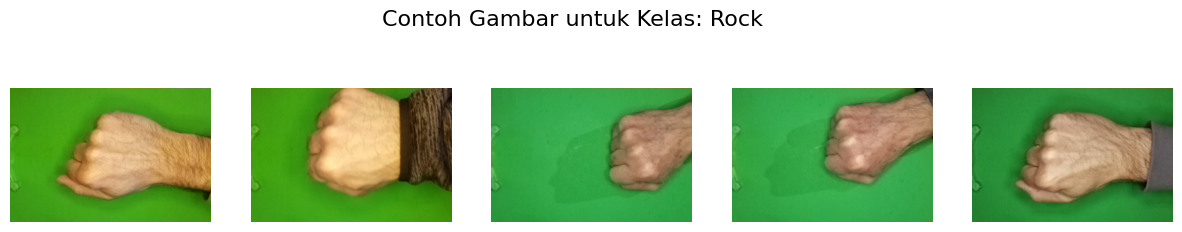

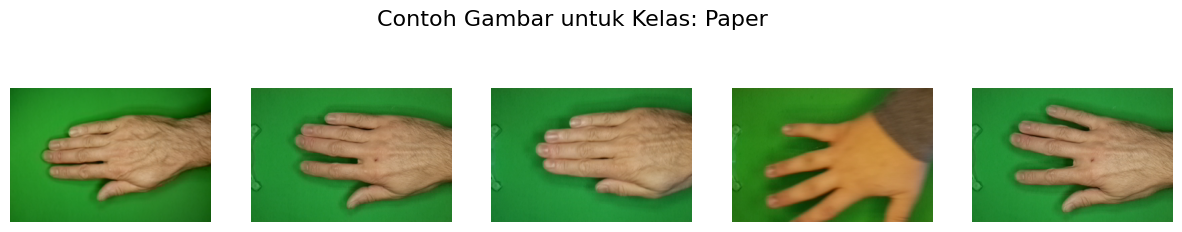

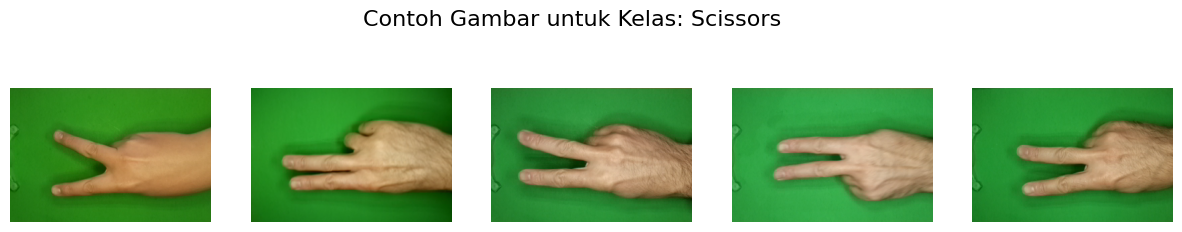

In [ ]:
# Menampilkan 5 contoh gambar untuk setiap kelas.

def show_sample_images(class_name, num_samples=5):
    plt.figure(figsize=(15, 3))
    plt.suptitle(f'Contoh Gambar untuk Kelas: {class_name.capitalize()}', fontsize=16)

    class_dir = os.path.join(base_dir, class_name)
    image_files = os.listdir(class_dir)[:num_samples]

    for i, file_name in enumerate(image_files):
        img_path = os.path.join(class_dir, file_name)
        img = load_img(img_path)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Tampilkan contoh untuk setiap kelas
show_sample_images('rock')
show_sample_images('paper')
show_sample_images('scissors')

Dengan melihat langsung contoh gambar dari setiap kelas (batu, gunting, kertas), kita bisa mengidentifikasi karakteristik umum, variasi, dan potensi tantangan yang ada. Pada dataset tiap gambar memiliki latar belakang berwarna hijau. Hal ini dilakukan karena pada tubuh manusia warna hijau sangat sedikit, sehingga dengan menggunakan latar belakang warna hijau dapat meningkatkan kinerja model dalam membedakan gerakan tangan dengan baik. Meskipun latar belakangnya seragam, terdapat variasi dalam pose tangan, sudut pengambilan gambar, dan pencahayaan. Hal ini menegaskan pentingnya langkah augmentasi data untuk membuat model lebih tangguh dan mampu melakukan generalisasi dengan baik.

## 2. Distribusi tiap kelas

/tmp/ipython-input-8-2676808584.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=image_counts, palette='viridis')


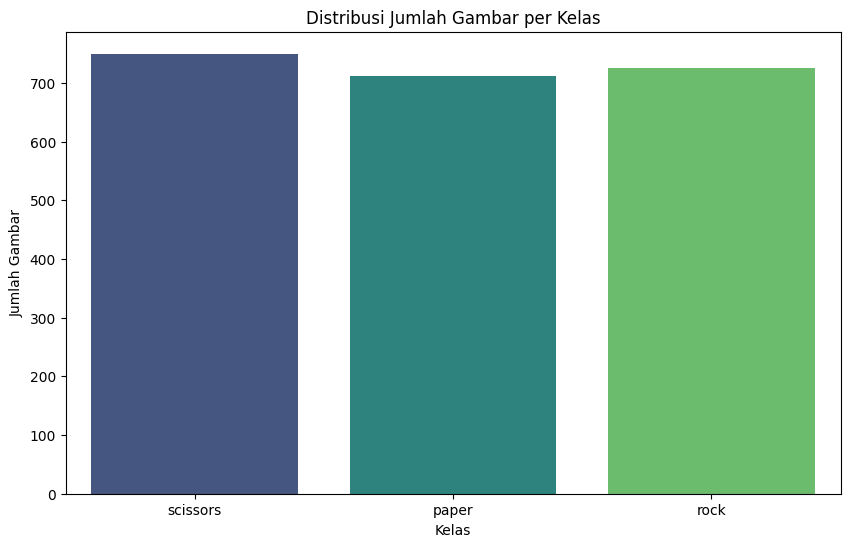

In [ ]:
# Direktori dasar
base_dir = 'tmp/rps-cv-images/'

#Dapatkan semua item di base_dir
all_items = os.listdir(base_dir)

#Filter untuk hanya mengambil direktori (folder)
class_names = [item for item in all_items if os.path.isdir(os.path.join(base_dir, item))]

#Hitung jumlah gambar di setiap direktori yang sudah difilter
image_counts = [len(os.listdir(os.path.join(base_dir, name))) for name in class_names]

# Membuat plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=image_counts, palette='viridis')
plt.title('Distribusi Jumlah Gambar per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.show()

In [ ]:
# Menulis jumlah gambar dari tiap kelas
print('Jumlah gambar batu:', len(os.listdir(rock_dir)))
print('Jumlah gambar kertas:', len(os.listdir(paper_dir)))
print('Jumlah gambar gunting:', len(os.listdir(scissors_dir)))

Jumlah gambar batu: 726
Jumlah gambar kertas: 712
Jumlah gambar gunting: 750


Dataset menggunakan jumlah gambar yang hampir seimbang atau tidak adanya data yang mendominasi. Karena data balance maka tidak perlu dilakukan oversampling atau undersampling pada tiap kelasnya. 

## 3. Analisis Dimensi Gambar

In [ ]:
# Mencari dimensinya dari dataset
def analyze_dimensions(class_name, num_samples=5):
    print(f"Analisis Dimensi untuk Kelas '{class_name}':")
    class_dir = os.path.join(base_dir, class_name)
    image_files = os.listdir(class_dir)[:num_samples]

    for file_name in image_files:
        with Image.open(os.path.join(class_dir, file_name)) as img:
            width, height = img.size
            print(f"- {file_name}: Lebar={width}px, Tinggi={height}px")
    print("-" * 30)

# Analisis dimensi untuk setiap kelas
analyze_dimensions('rock')
analyze_dimensions('paper')
analyze_dimensions('scissors')

Analisis Dimensi untuk Kelas 'rock':
- MhOAtto6kcc8xsKr.png: Lebar=300px, Tinggi=200px
- nY37eRslka1ss2bZ.png: Lebar=300px, Tinggi=200px
- 6QrCGRwuFLPn0VIH.png: Lebar=300px, Tinggi=200px
- JXD8WyY4cQoEyvtU.png: Lebar=300px, Tinggi=200px
- bn4i63wrObqbJECw.png: Lebar=300px, Tinggi=200px
------------------------------
Analisis Dimensi untuk Kelas 'paper':
- tW1oIjn0hlGLToAY.png: Lebar=300px, Tinggi=200px
- YnANqAVHDOylhBls.png: Lebar=300px, Tinggi=200px
- HTETrKtTEB31pvsK.png: Lebar=300px, Tinggi=200px
- VFOCgVBUlL5Gp4Hh.png: Lebar=300px, Tinggi=200px
- RmJmYq6VCNrrvi2l.png: Lebar=300px, Tinggi=200px
------------------------------
Analisis Dimensi untuk Kelas 'scissors':
- Y2lr5d6VnNfievnA.png: Lebar=300px, Tinggi=200px
- nIwv11WKj5Ch85mv.png: Lebar=300px, Tinggi=200px
- ntwoVP9pgUbs3LGq.png: Lebar=300px, Tinggi=200px
- DXQaN15KphkE4i7z.png: Lebar=300px, Tinggi=200px
- UO03gubyPNMaJ8pj.png: Lebar=300px, Tinggi=200px
------------------------------


Pada dataset memiliki ukuran dimensi gambar yang sama. Berdasarkan hal ini tidak perlu dilakukan adanya standarisasi karena semua data berukuran sama.

## 4. Analisis jenis warna

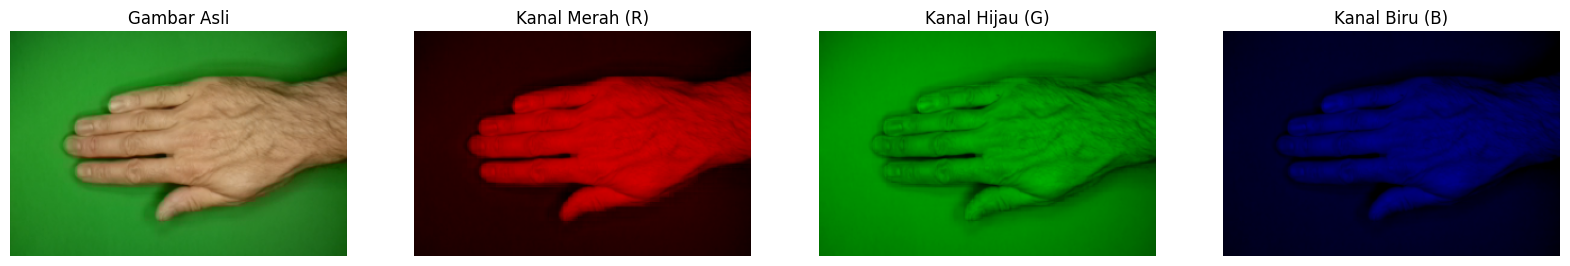

In [ ]:
# Memisahkan dan menampilkan pengaturan tampilan R, G, B dari satu gambar.
# Mengambil salah satu gambar dari dataset
paper_dir = os.path.join(base_dir, 'paper')
paper_files = os.listdir(paper_dir)
img_path = os.path.join(paper_dir, paper_files[0])
img = np.array(Image.open(img_path))

# Pisahkan kanal R, G, B
r_channel = img.copy(); r_channel[:, :, (1, 2)] = 0
g_channel = img.copy(); g_channel[:, :, (0, 2)] = 0
b_channel = img.copy(); b_channel[:, :, (0, 1)] = 0

# Plot gambar asli dan setiap kanalnya
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(img); axes[0].set_title('Gambar Asli'); axes[0].axis('off')
axes[1].imshow(r_channel); axes[1].set_title('Kanal Merah (R)'); axes[1].axis('off')
axes[2].imshow(g_channel); axes[2].set_title('Kanal Hijau (G)'); axes[2].axis('off')
axes[3].imshow(b_channel); axes[3].set_title('Kanal Biru (B)'); axes[3].axis('off')
plt.show()

Berdasarkan analisis ini jika gambar diubah menjadi hijau maka bentuk tangan tidak terlalu terlihat. Sehingga model sebaiknya tidak terlalu memprioritaskan bobot pada fitur di kanal warna hijau.

## 5. Analisis letak objek

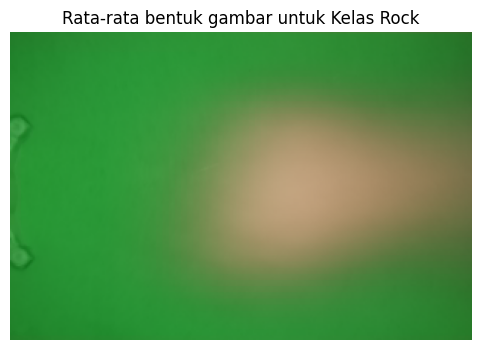

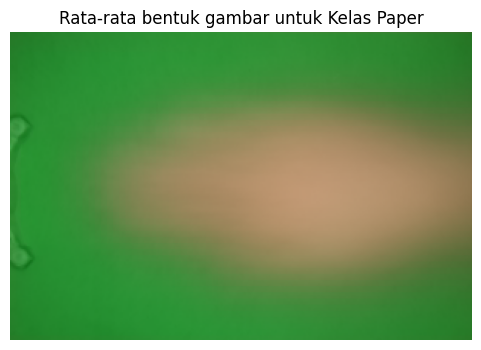

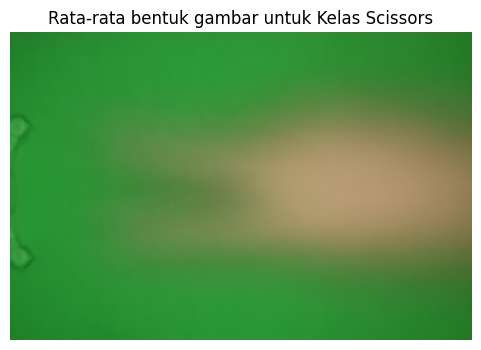

In [ ]:
# Menghitung letak dan menampilkan gambar rata-rata untuk setiap kelas.
def plot_average_image(class_name):
    class_dir = os.path.join(base_dir, class_name)
    image_files = os.listdir(class_dir)

    # Inisialisasi array
    average_image = np.zeros((200, 300, 3), dtype=float)

    # Loop melalui semua gambar
    for file_name in image_files:
        img = np.array(Image.open(os.path.join(class_dir, file_name)), dtype=float)
        average_image += img

    # Bagi dengan jumlah gambar untuk mendapatkan rata-rata
    average_image /= len(image_files)

    # Tampilkan gambar rata-rata
    plt.figure(figsize=(6, 4))
    plt.imshow(average_image.astype(np.uint8))
    plt.title(f'Rata-rata bentuk gambar untuk Kelas {class_name.capitalize()}')
    plt.axis('off')
    plt.show()

# Plot untuk setiap kelas
plot_average_image('rock')
plot_average_image('paper')
plot_average_image('scissors')

Berdasarkan hasil analisis gambar, posisi tangan selalu sama. Sehingga pada model harus dibuat data baru untuk mengubah posisi dari tiap tangan agar model memiliki performa yang lebih baik dalam membaca posisi tangan.

## 6. Analisis Intensitas piksel dari tiap gambar.

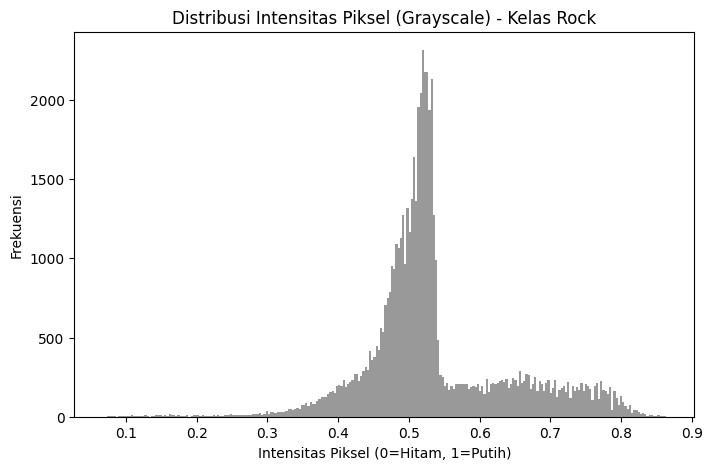

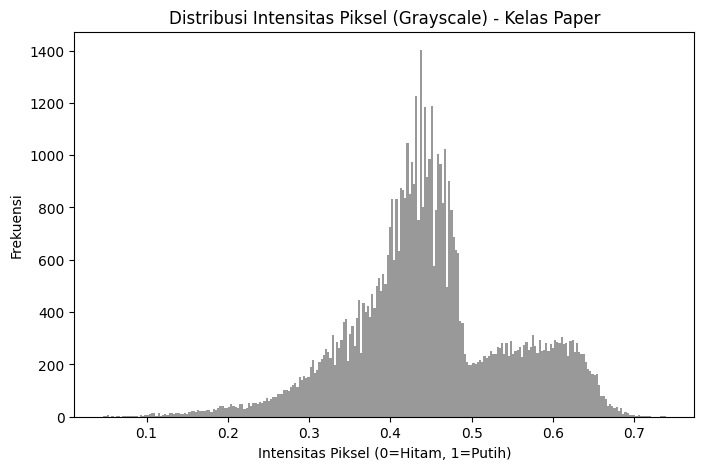

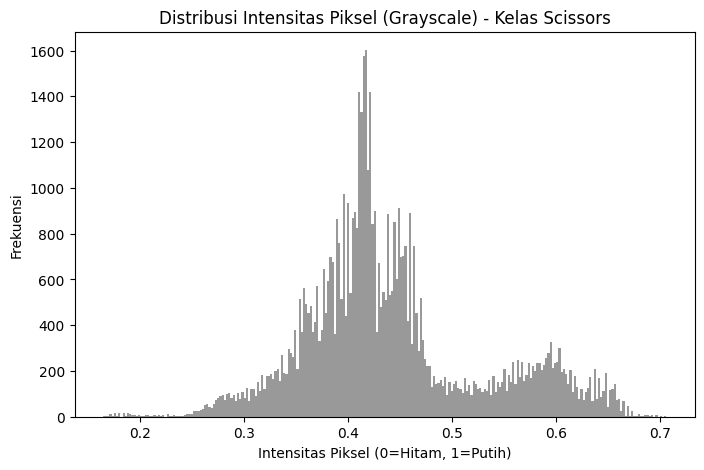

In [ ]:
# Mengambil satu contoh gambar, mengubahnya menjadi grayscale, dan memplot histogram intensitas pikselnya.
def plot_pixel_intensity(class_name):
    # Ambil satu gambar contoh
    class_dir = os.path.join(base_dir, class_name)
    img_path = os.path.join(class_dir, os.listdir(class_dir)[0])
    img = np.array(Image.open(img_path))

    # Ubah ke grayscale
    gray_img = rgb2gray(img)

    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.hist(gray_img.ravel(), bins=256, color='gray', alpha=0.8)
    plt.title(f'Distribusi Intensitas Piksel (Grayscale) - Kelas {class_name.capitalize()}')
    plt.xlabel('Intensitas Piksel (0=Hitam, 1=Putih)')
    plt.ylabel('Frekuensi')
    plt.show()

# Plot untuk setiap kelas
plot_pixel_intensity('rock')
plot_pixel_intensity('paper')
plot_pixel_intensity('scissors')

Berdasarkan frekusensi warna yang telah diubah menjadi hitam putih, histogram menunjukkan adanya dua puncak (peak) yang jelas yang merepresentasikan piksel tangan, sedangkan puncak di area intensitas tinggi (terang) merepresentasikan piksel latar belakang hijau. Sehingga pada dataset ini memiliki nilai kontras yang cukup baik dan akan memudahkan model dalam mendeteksi bentuk tangan.

# V. Feature Engineering

In [ ]:
# Mendefinisikan ImageDataGenerator dengan transformasi yang lebih ekstensif
# untuk membuat model lebih tangguh terhadap variasi posisi, rotasi, dll.

# 1. Mendefinisikan Generator untuk Data Pelatihan dengan Augmentasi Lengkap
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Rescale nilai piksel dari 0-255 menjadi 0-1
    rotation_range=25,              # Rotasi gambar secara acak hingga 40 derajat agar model gambar tidak monoton.
    width_shift_range=0.2,          # Geser gambar secara horizontal hingga 20% dari lebarnya agar model membaca apabila posisi tangan berbeda dari dataset.
    height_shift_range=0.2,         # Geser gambar secara vertikal hingga 20% dari tingginya agar model dapat membaca apabila posisi tangan berbeda dari dataset.
    shear_range=0.1,                # Lakukan transformasi geser (shear) hingga 10% agar model dapat juga membaca apabila posisi tangan berbeda dari dataset.
    zoom_range=0.2,                 # Lakukan zoom pada gambar hingga 20% agar data tidak terlalu fokus untuk mengukur dari jarak yang sama.
    horizontal_flip=True,           # Balik gambar secara horizontal agar data tidak selalu berasal dari kanan gambar. TIDAK DILAKUKAN VERTICAL CLIP KARENA DALAM DATASET SUDAH MENGGUNAKAN TANGAN KIRI DAN KANAN.
    fill_mode='nearest',            # Isi piksel yang kosong setelah transformasi dengan piksel terdekat
    validation_split=0.2            # Memisahkan 20% data untuk validasi
)

# 2. Mendefinisikan Generator untuk Data Validasi.
# Penting: Data validasi tidak boleh di-augmentasi. Tujuannya adalah untuk
# Mengevaluasi performa model pada data yang "bersih" dan asli.
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


# 3. Terapkan Generator pada Direktori Data
image_size = (150, 150) # Mengurangi ukuran piksel dari 300x200 menjadi 150x150 agar pelatihan menjadi lebih cepat.
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


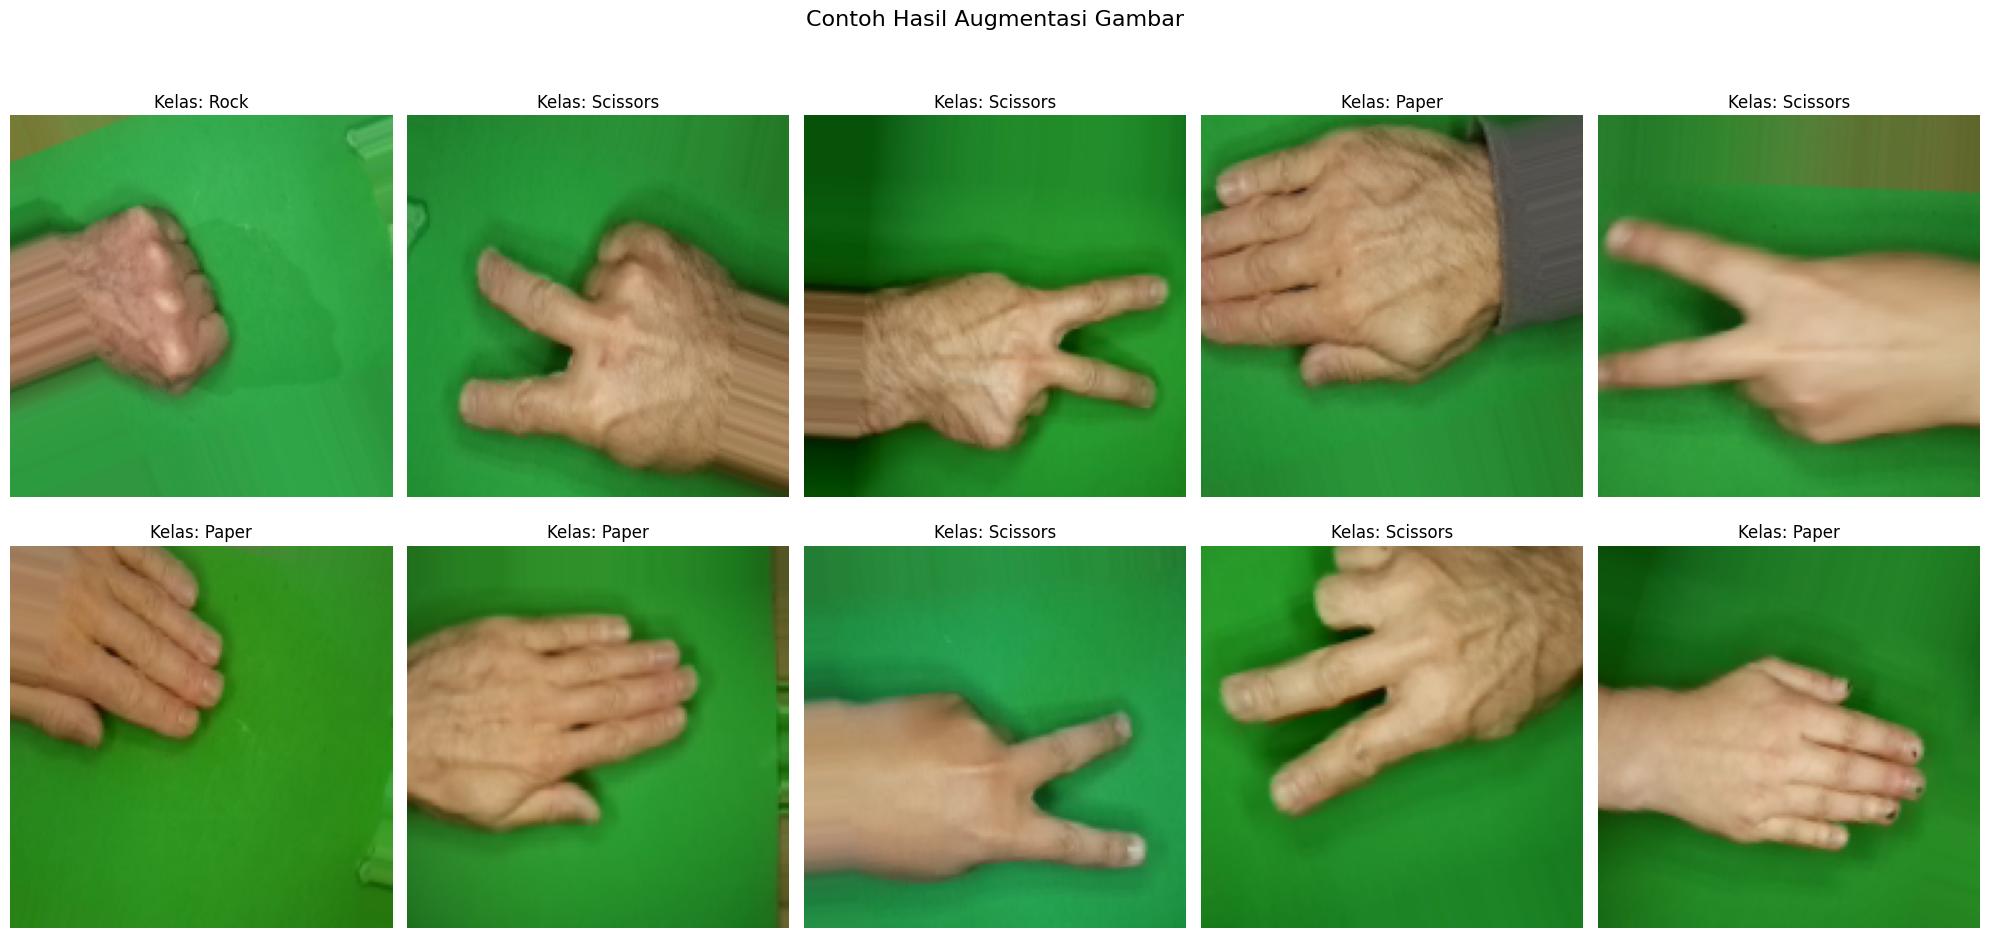

In [ ]:
# Menampilkan contoh gambar hasil augmentasi
# 1. Ambil satu batch gambar dan label dari generator
# next() adalah cara standar untuk mengambil satu item dari generator
images, labels = next(train_generator)

# 2. Dapatkan nama kelas dari generator
# train_generator.class_indices akan memberikan dictionary seperti {'paper': 0, 'rock': 1, 'scissors': 2}
# Kita perlu membaliknya agar bisa mencari nama dari indeks
class_names = list(train_generator.class_indices.keys())

# 3. Siapkan plot untuk menampilkan 10 gambar
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
fig.suptitle('Contoh Hasil Augmentasi Gambar', fontsize=16)

# 4. Loop dan tampilkan setiap gambar
for i, ax in enumerate(axes.flat):
    # Tampilkan gambar (imshow bisa langsung handle format float 0-1)
    ax.imshow(images[i])

    # Cari nama kelas dari label yang berbentuk one-hot encoding
    # np.argmax akan menemukan indeks dengan nilai 1.0
    label_index = np.argmax(labels[i])
    class_name = class_names[label_index]

    ax.set_title(f'Kelas: {class_name.capitalize()}')
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.92) # Beri sedikit ruang untuk suptitle
plt.show()

Penambahan dataset agar model dapat belajar lebih baik, dataset ditambahkan gambar yang sudah diaugmentasi.

# VI. ANN TRAINING

## VI. 1. Model Definition

In [ ]:
model_basic = Sequential([
    # Layer Konvolusi dan Pooling 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2), # Mengecilkan ukuran gambar

    # Layer Konvolusi dan Pooling 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Layer Konvolusi dan Pooling 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Meratakan output untuk dihubungkan ke layer Dense
    Flatten(),

    # Layer Dropout untuk mencegah overfitting
    Dropout(0.6),

    # Layer Fully Connected (Dense)
    Dense(256, activation='relu'),
    Dense(3, activation='softmax')
])

# Meng-compile model
model_basic.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Menampilkan ringkasan arsitektur model
model_basic.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

- Pengaturan hidden layers dan neuron agar model dapat banyak belajar dengan lebih banyak. 

- Penggunaan maxpooling untuk melakukan downsampling tapi dengan nilai maksimum tiap pikselnya, agar komputasi model lebih efisien tapi penurunan tidak terlalu banyak.

- Dengan peningkatan nilai filter ditujukan agar model dapat membentuk pola yang lebih kompleks dan spesifik.

- Flatten digunakan untuk membuat output berbentuk grid 2D menjadi satu vektor 1D. 

- Nilai dropout digunakan untuk mencegah overfitting selama pelatihan. 0.6 berarti model akan mematikan 60% neuron, sehingga model tidak terlalu bergantung satu jalur informasi dan belajar dengan lebih merata, agar kemampuan generalisasinya dapat meningkat.

- Model menggunakan ReLU untuk mencegah model menjadi sekadar fungsi garis lurus yang sederhana tapi dapat menjadi sebuah garis yang melengkung. ReLU akan mengubah semua nilai negatif menjadi nol, sehingga model dapat belajar dengan lebih kompleks seperti lekukan jari atau kepalan tangan. 

- Model menggunakan softmax akan mengubah skor dari model menjadi lebih pasti. 

- Model menggunakan optimizer adam karena algoritma ini akan mempebaharui bobot model berdasarkan loss yang sudah dihitung, sehingga model dapat belajar dari kesalahannya.

- Untuk loss function menggunakan categorical_crossentropy, karena klasifikasinya lebih dari dua kelas.

- Metrik accuracy digunakan karena metrik ini mudah dipahami untuk melihat seberapa baik model bekerja dalam menentukan persentase tebakan yang benar.



## VI. 2. Model Training

In [ ]:
# Melatih model CNN yang telah didefinisikan.

epochs = 20

history_basic = model_basic.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    verbose=2
)

Epoch 1/20
54/54 - 76s - loss: 1.1631 - accuracy: 0.3688 - val_loss: 1.0568 - val_accuracy: 0.4062 - 76s/epoch - 1s/step
Epoch 2/20
54/54 - 75s - loss: 1.0123 - accuracy: 0.4974 - val_loss: 0.7346 - val_accuracy: 0.8077 - 75s/epoch - 1s/step
Epoch 3/20
54/54 - 75s - loss: 0.7274 - accuracy: 0.6841 - val_loss: 0.4782 - val_accuracy: 0.8125 - 75s/epoch - 1s/step
Epoch 4/20
54/54 - 74s - loss: 0.5752 - accuracy: 0.7650 - val_loss: 0.3341 - val_accuracy: 0.9111 - 74s/epoch - 1s/step
Epoch 5/20
54/54 - 71s - loss: 0.5182 - accuracy: 0.7993 - val_loss: 0.2900 - val_accuracy: 0.9014 - 71s/epoch - 1s/step
Epoch 6/20
54/54 - 72s - loss: 0.5138 - accuracy: 0.7882 - val_loss: 0.2982 - val_accuracy: 0.8822 - 72s/epoch - 1s/step
Epoch 7/20
54/54 - 71s - loss: 0.4821 - accuracy: 0.8133 - val_loss: 0.2504 - val_accuracy: 0.9135 - 71s/epoch - 1s/step
Epoch 8/20
54/54 - 73s - loss: 0.4607 - accuracy: 0.8168 - val_loss: 0.2590 - val_accuracy: 0.9159 - 73s/epoch - 1s/step
Epoch 9/20
54/54 - 71s - loss: 0

## VI. 3. Model Evaluation

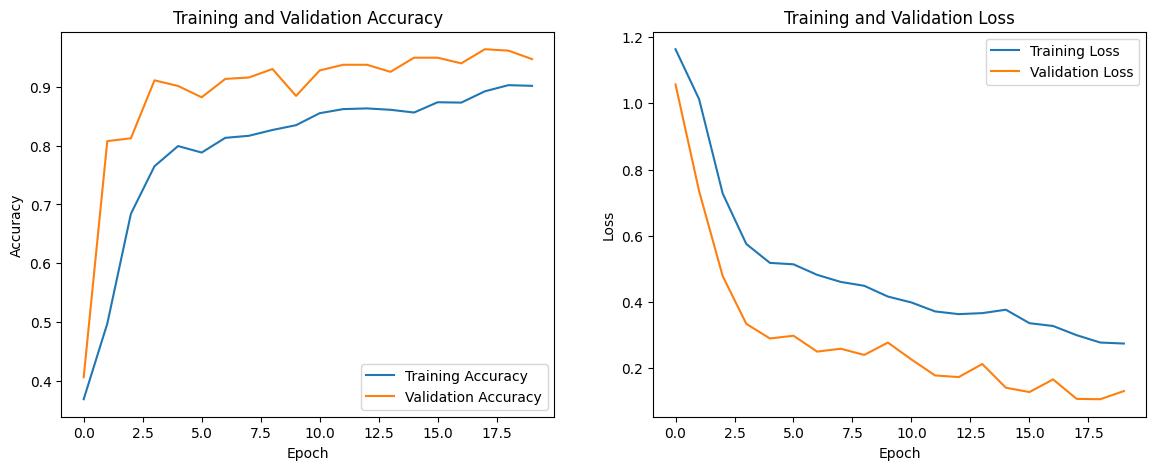

In [ ]:
# Membuat visualisasi dari histori pelatihan model.

acc = history_basic.history['accuracy']
val_acc = history_basic.history['val_accuracy']
loss = history_basic.history['loss']
val_loss = history_basic.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

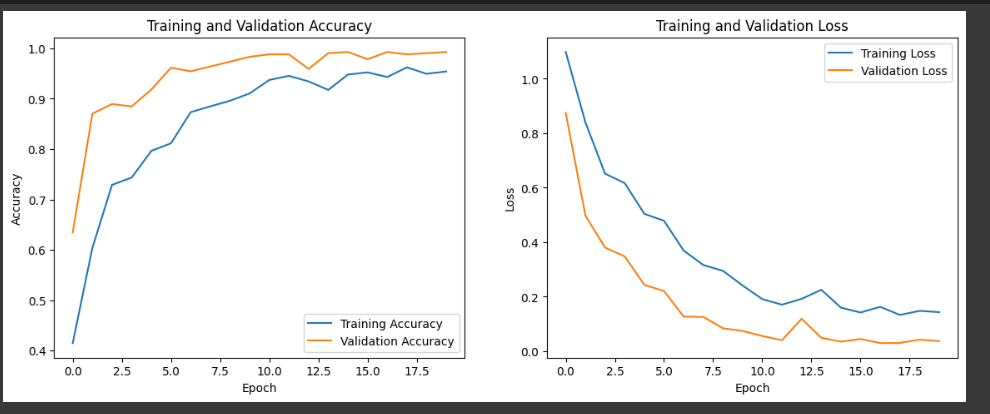

# VII. ANN Improvement

## VII. 1. Model definition

In [ ]:
# Memuat base model MobileNetV2 yang sudah dilatih di ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Membekukan (freeze) bobot dari base model agar tidak ikut terlatih
base_model.trainable = False

# Membuat model baru di atas base model
model_improved = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Meng-compile model dengan learning rate yang lebih rendah
model_improved.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Menampilkan ringkasan arsitektur model
model_improved.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                         

- Model menggunakan ReLU untuk mencegah model menjadi sekadar fungsi garis lurus yang sederhana tapi dapat menjadi sebuah garis yang melengkung. ReLU akan mengubah semua nilai negatif menjadi nol, sehingga model dapat belajar dengan lebih kompleks seperti lekukan jari atau kepalan tangan. 

- Model menggunakan softmax akan mengubah skor dari model menjadi lebih pasti. 

- Model menggunakan categorical crossentropy karena nilai ini cocok dengan output softmax, sehingga membuat proses pembelajaran dari kesalahan menjadi sangat efisien.

- Model menggunakan metrics accuracy karena metrik ini paling baik dalam mengukur keberhasilan dalam tugas klasifikasi.

## VII. 2. Model Training

In [ ]:
# Callbacks untuk menghentikan pelatihan lebih awal dan mengurangi learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history_improved = model_improved.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

Epoch 1/20
54/54 - 40s - loss: 0.9249 - accuracy: 0.6114 - val_loss: 0.2745 - val_accuracy: 0.9447 - lr: 1.0000e-04 - 40s/epoch - 732ms/step
Epoch 2/20
54/54 - 34s - loss: 0.4381 - accuracy: 0.8330 - val_loss: 0.1580 - val_accuracy: 0.9688 - lr: 1.0000e-04 - 34s/epoch - 632ms/step
Epoch 3/20
54/54 - 33s - loss: 0.3080 - accuracy: 0.8895 - val_loss: 0.1314 - val_accuracy: 0.9663 - lr: 1.0000e-04 - 33s/epoch - 615ms/step
Epoch 4/20
54/54 - 39s - loss: 0.2505 - accuracy: 0.9168 - val_loss: 0.0924 - val_accuracy: 0.9760 - lr: 1.0000e-04 - 39s/epoch - 722ms/step
Epoch 5/20
54/54 - 35s - loss: 0.1838 - accuracy: 0.9436 - val_loss: 0.0799 - val_accuracy: 0.9760 - lr: 1.0000e-04 - 35s/epoch - 643ms/step
Epoch 6/20
54/54 - 33s - loss: 0.1781 - accuracy: 0.9447 - val_loss: 0.0640 - val_accuracy: 0.9784 - lr: 1.0000e-04 - 33s/epoch - 611ms/step
Epoch 7/20
54/54 - 38s - loss: 0.1758 - accuracy: 0.9430 - val_loss: 0.0593 - val_accuracy: 0.9808 - lr: 1.0000e-04 - 38s/epoch - 709ms/step
Epoch 8/20
54

## VII. 3. Model Evaluation

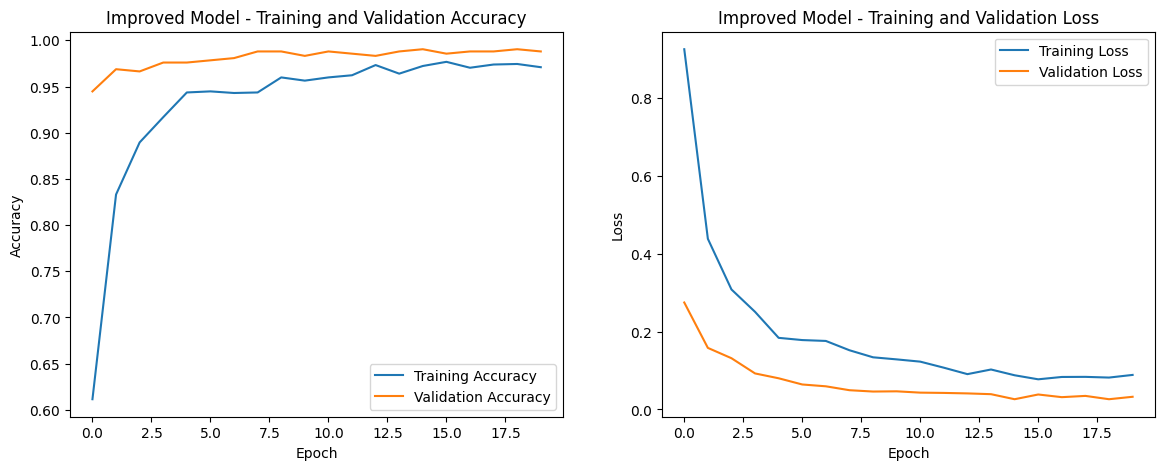

In [ ]:
# Membuat visualisasi dari histori pelatihan model kedua.

acc_imp = history_improved.history['accuracy']
val_acc_imp = history_improved.history['val_accuracy']
loss_imp = history_improved.history['loss']
val_loss_imp = history_improved.history['val_loss']

epochs_range_improved = range(len(acc_imp))

plt.figure(figsize=(14, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range_improved, acc_imp, label='Training Accuracy')
plt.plot(epochs_range_improved, val_acc_imp, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Improved Model - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range_improved, loss_imp, label='Training Loss')
plt.plot(epochs_range_improved, val_loss_imp, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Improved Model - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

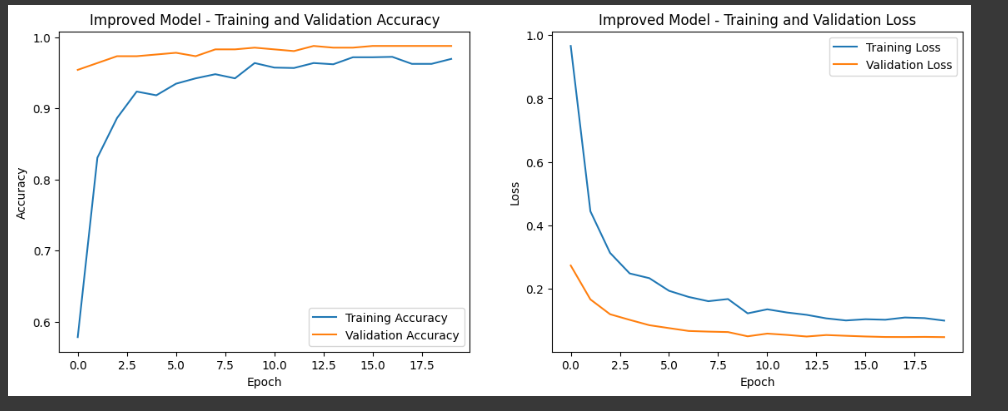

# VIII. Model Saving

In [ ]:
# Menyimpan model terbaik ke dalam file .h5

best_model = model_improved
best_model.save('rock_paper_scissors_model.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# IX. Model Inference

Model inference dijalankan dalam file model_inference.ipynb

# X. Kesimpulan

1. Berdasarkan proses EDA dapat kita ambil beberapa kesimpulan
- Dataset berkualitas tinggi dengan distribusi kelas yang seimbang dan latar belakang seragam, sehingga mempermudah pembuatan model. 
- Berdasarkan analisis letak diperlukan beberapa dataset tambahan agar model tidak terlalu memprediksi pola tangan dari sisi kanan gambar.

2. Model CNN menjadi baseline yang cukup baik. Hal ini membuktikan bahwa model dasar sudah mampu menangkap fitur-fitur esensial dari gambar tangan dengan efektif.

3. Tranfer Learning dengan arsitektur MobileNetV2 menunjukkan peningkatan performa yang signifikan. Model tidak hanya mencapai akurasi yang lebih tinggi, tetapi juga menunjukkan konvergensi yang lebih cepat dan stabil. 

4. Pemilihan MobileNetV2 karena arsitektur lebih akurat dan efisien. MobileNetV2 dapat melakukan pemindaian spasial pada setiap kanal warna secara terpisah lalu menggabungkan hasil dari proses tersebut untuk menciptakan fitur baru. 

5. Pemilihan Sequential API karena model cukup sederhana tapi tetap jelas. Karena sederhana maka cocok untuk digunakan sebagai baseline. Functional API lebih cocok digunakan digunakan saat menggunakan beberapa input dan beberapa output. Namun pada dataset ini input hanya berupa gambar dan output juga prediksi gambar.  

6. Pada dataset latar hanya berwarna hijau sehingga jika saat memprediksi terdapat objek lain model akan kesulitan membaca objek. Yang mengakibatkan nilai akurasi turun dan akan terjadi kesalahan dalam memprediksi hasil.

6. Pada model inference jika gambar berisikan dua objek, maka model salah memprediksi hasil. Sehingga perlu dijelaskan bahwa model ini hanya untuk mendeteksi satu objek saja. Jika mendeteksi satu objek maka dapat membaca dengan baik.
